In [1]:
!pip install pytorch-lightning
!pip install wandb
!pip install torchinfo
!pip install wandb

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torchvision import transforms, datasets
from PIL import Image
import torch.nn.functional as F
from typing import Tuple, Dict, List
from pathlib import Path
import pytorch_lightning as pl
import os
import struct
import requests
import numpy as np
import wandb

In [3]:

def download_file(url, filename):
    """Download a file from a URL to the given filename."""
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)

def read_idx(filename):
    """Read an IDX file and return it as a numpy array."""
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

def save_images(images, labels, directory):
    """Save images to the specified directory with labels as filenames."""
    os.makedirs(directory, exist_ok=True)
    for i, (image, label) in enumerate(zip(images, labels)):
        image_path = os.path.join(directory, f"{i}_{label}.png")
        Image.fromarray(image).save(image_path)

# URLs for the MNIST dataset
urls = {
    "train_images": "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
    "train_labels": "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
    "test_images": "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
    "test_labels": "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
}

# Download and unzip MNIST dataset
for name, url in urls.items():
    filename = url.split("/")[-1]
    filepath = os.path.join("mnist_data", filename)
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    if not os.path.exists(filepath[:-3]):  # Check if the unzipped file exists
        print(f"Downloading {filename}...")
        download_file(url, filepath)
        print(f"Extracting {filename}...")
        os.system(f"gunzip -k {filepath}")

# Read IDX files and convert to numpy arrays
train_images = read_idx("mnist_data/train-images-idx3-ubyte")
train_labels = read_idx("mnist_data/train-labels-idx1-ubyte")
test_images = read_idx("mnist_data/t10k-images-idx3-ubyte")
test_labels = read_idx("mnist_data/t10k-labels-idx1-ubyte")

# Save images to folders
save_images(train_images, train_labels, "mnist_data/train_images")
save_images(test_images, test_labels, "mnist_data/test_images")

print("MNIST dataset has been processed and saved as images.")


MNIST dataset has been processed and saved as images.


In [4]:
class CustomMnist(Dataset) :
  def __init__(self, path: str, transform: transforms.Compose) -> None:
    self.path = list(path.glob('*'))
    self.transform = transform
  def load_image(self, idx) -> Image.Image:
     image = Image.open(self.path[idx])
     return image
  def __len__(self) -> int:
    return len(self.path)
  def __getitem__(self, idx) -> torch.tensor:
     image = self.transform(self.load_image(idx))
     return image

In [5]:
class MnistDataModule(pl.LightningDataModule) :
  def __init__(self, train_dir, test_dir, transform, batch_size, num_workers) :
    super().__init__()
    self.train_dir = train_dir
    self.test_dir = test_dir
    self.batch_size = batch_size
    self.num_workers = num_workers
    self.transform = transform
  def prepare_data(self) :
    CustomMnist(self.train_dir, self.transform)
    CustomMnist(self.test_dir, self.transform)

  def setup(self, stage) :
    entire_ds = CustomMnist(self.train_dir, self.transform)
    self.train_ds, self.val_ds = random_split(entire_ds, [50000, 10000])
    self.test_ds = CustomMnist(self.test_dir, self.transform)
  def train_dataloader(self) :
    return DataLoader(dataset = self.train_ds,
                              batch_size = self.batch_size,
                              num_workers = self.num_workers,
                              shuffle = True)
  def val_dataloader(self) :
    return DataLoader(dataset = self.val_ds,
                              batch_size = self.batch_size,
                              num_workers = self.num_workers,
                              shuffle = True)
  def test_dataloader(self) :
    return DataLoader(dataset = self.test_ds,
                              batch_size = self.batch_size,
                              num_workers = self.num_workers,
                              shuffle = False)

In [6]:
train_dir = Path('/content/mnist_data/train_images')
test_dir = Path('/content/mnist_data/test_images')


In [7]:
transform = transforms.Compose([transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    ])

In [8]:
dm = MnistDataModule(train_dir=train_dir, test_dir=test_dir, transform=transform, batch_size=64, num_workers=0)

In [9]:
class ResidualBlocK(nn.Module) :
  def __init__(self, hidden_units) :
    super().__init__()
    self.relu1 = nn.ReLU()
    self.conv1 = nn.Conv2d(in_channels=hidden_units,
                           out_channels=hidden_units,
                           kernel_size=3, padding=1)
    self.relu2 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=hidden_units,
                           out_channels=hidden_units,
                           kernel_size=1)
  def forward(self, x) :
    _x = self.conv1(self.relu1(x))
    _x = self.conv2(self.relu2(_x))
    return x + _x
class VQVAE(pl.LightningModule) :
  def __init__(self,
               input_size: int = 64,
               hidden_units: int = 256,
               latent_size: int = 3,
               emb_size: int = 2,
               beta: int = 0.2,
               lr: float = 2e-4
               ) :
    super().__init__()
    self.save_hyperparameters()
    self.beta = beta
    self.lr = lr
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=3,
                  out_channels=hidden_units,
                  kernel_size=4,
                  stride=2,
                  padding=1),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=4,
                  stride=2,
                  padding=1),
        ResidualBlocK(hidden_units),
        ResidualBlocK(hidden_units)
    )
    self.pre_quant_conv = nn.Conv2d(in_channels=hidden_units,
                                    out_channels=emb_size,
                                    kernel_size=1)
    self.emb = nn.Embedding(num_embeddings=latent_size, embedding_dim=emb_size)
    self.post_quant_conv = nn.Conv2d(in_channels=emb_size,
                                     out_channels=hidden_units,
                                     kernel_size=1)
    self.decoder = nn.Sequential(
        ResidualBlocK(hidden_units),
        ResidualBlocK(hidden_units),
        nn.ConvTranspose2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=4,
                  stride=2,
                  padding=1),
        nn.ConvTranspose2d(in_channels=hidden_units,
                  out_channels=3,
                  kernel_size=4,
                  stride=2,
                  padding=1),
    )
  def forward(self, x) :
    x = self.encoder(x)
    x = self.pre_quant_conv(x)
    b, c, h, w = x.shape
    x = x.permute(0, 2, 3, 1)
    x = x.reshape(x.size(0), -1, x.size(-1))
    emb_w = self.emb.weight[None:].repeat((x.size(0), 1, 1))
    dist = torch.cdist(x, emb_w)
    min_encoding_indices = torch.argmin(dist, dim=-1)
    quant_out = torch.index_select(input=self.emb.weight, dim=0, index=min_encoding_indices.view(-1))
    x = x.reshape((-1, x.size(-1)))
    commitment_loss = torch.mean((x.detach() - quant_out)**2)
    codebook_loss = torch.mean((x - quant_out.detach())**2)
    vq_loss = codebook_loss + commitment_loss * self.beta
    quant_out = x + (quant_out - x).detach()
    quant_out = quant_out.reshape(b, h, w, c)
    quant_out = quant_out.permute(0, 3, 1, 2)
    quant_out = self.post_quant_conv(quant_out)
    output = self.decoder(quant_out)
    return output, vq_loss, quant_out
  def training_step(self, batch, batch_idx):
    output, vq_loss, quant_out = self._common_step(batch, batch_idx)
    wandb.log({"Training Loss": vq_loss})
    return vq_loss
  def validation_step(self, batch, batch_idx) :
    output, vq_loss, quant_out = self._common_step(batch, batch_idx)
    # to_pil = transforms.ToPILImage()
    # columns = ["inputs", "reconstructions"]
    # img1 = to_pil(batch[0])
    # img2 = to_pil(output[0])
    # my_data = [
    #     ["inputs", wandb.Image(batch)],
    #     ["reconstructions", wandb.Image(output)],
    # ]
    # wandb_logger.log_table(key="my_samples", columns=columns, data=my_data)
    if batch_idx % 100 == 0 :
      wandb.log({"input": [wandb.Image(batch, caption=f"Batch: {batch_idx}")],
                "output": [wandb.Image(output, caption=f"Batch: {batch_idx}")]
                }, commit=False)
    wandb.log({"Validation Loss": vq_loss})
    return  vq_loss
  def test_step(self, batch, batch_idx) :
    output, vq_loss, quant_out = self._common_step(batch, batch_idx)
    wandb.log({"Test Loss": vq_loss})
    return vq_loss
  def _common_step(self, batch, batch_idx) :
    x = batch
    output, vq_loss, quant_out = self.forward(x)

    return output, vq_loss, quant_out
  def configure_optimizers(self) :
    return torch.optim.Adam(params=self.parameters(), lr = self.lr)
  def on_epoch_end(self):
        # Log images
    sample_input = torch.randn(1, 3, self.hparams.input_size, self.hparams.input_size)
    sample_output, _, sample_latent = self.forward(sample_input)

    sample_input_grid = torchvision.utils.make_grid(sample_input)
    sample_output_grid = torchvision.utils.make_grid(sample_output)
    # sample_latent_grid = torchvision.utils.make_grid(sample_latent)

    wandb.log({"Sample Input": [wandb.Image(sample_input_grid, caption="Sample Input")]})
    wandb.log({"Sample Output": [wandb.Image(sample_output_grid, caption="Sample Output")]})
    # wandb.log({"Sample Latent Space": [wandb.Image(sample_latent_grid, caption="Sample Latent Space")]})

In [10]:
model = VQVAE(input_size=64,
              hidden_units=256,
              latent_size=3,
              emb_size=2,
              beta=0.2,
              lr=2e-4).to('cuda')

In [11]:
from torchinfo import summary
summary(model,
        input_size = (8,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
VQVAE                                    [8, 3, 64, 64]            6
├─Sequential: 1-1                        [8, 256, 16, 16]          --
│    └─Conv2d: 2-1                       [8, 256, 32, 32]          12,544
│    └─Conv2d: 2-2                       [8, 256, 16, 16]          1,048,832
│    └─ResidualBlocK: 2-3                [8, 256, 16, 16]          --
│    │    └─ReLU: 3-1                    [8, 256, 16, 16]          --
│    │    └─Conv2d: 3-2                  [8, 256, 16, 16]          590,080
│    │    └─ReLU: 3-3                    [8, 256, 16, 16]          --
│    │    └─Conv2d: 3-4                  [8, 256, 16, 16]          65,792
│    └─ResidualBlocK: 2-4                [8, 256, 16, 16]          --
│    │    └─ReLU: 3-5                    [8, 256, 16, 16]          --
│    │    └─Conv2d: 3-6                  [8, 256, 16, 16]          590,080
│    │    └─ReLU: 3-7                    [8, 256, 16, 16]    

In [11]:
import wandb
wandb.init(project='VQ-VAE', name='TrainingVisualize3')

wandb: Currently logged in as: phamnhutcongviec (vjocr). Use `wandb login --relogin` to force relogin


In [ ]:
from pytorch_lightning.loggers.wandb import WandbLogger
wandb_logger = WandbLogger(project='VQ-VAE', name='TrainingTestVisualize2')
trainer = pl.Trainer(accelerator = 'gpu',
                     min_epochs=1,
                     max_epochs=100,
                     precision=16,
                     logger = wandb_logger

                    #  callbacks = [MyPrintingCallBack(), EarlyStopping(monitor="val_loss")]
                     )
trainer.fit(model, dm)
trainer.validate(model, dm)
trainer.test(model, dm)


/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [25]:
wandb.finish()

In [ ]:
def visualize_samples(sample_output, sample_latent, sample_input):
    # Convert PyTorch tensors to numpy arrays for visualization
    output_image = sample_output.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    first_channel = sample_latent[:, 0, :, :]  # Selecting the first channel
    first_channel_numpy = first_channel.squeeze().cpu().detach().numpy()
    # latent_image = first_channel.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    input_image = sample_input.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

    # Display the images using Matplotlib
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(input_image)
    axs[0].set_title('Input Image')
    axs[0].axis('off')

    axs[1].imshow(output_image)
    axs[1].set_title('Output Image')
    axs[1].axis('off')

    axs[2].imshow(first_channel_numpy, cmap='gray')
    axs[2].set_title('Latent Space Image')
    axs[2].axis('off')

    plt.show()

In [ ]:

train_set = CustomMnist(train_dir, transform)

In [ ]:
sample_input = train_set[0].unsqueeze(0)

In [ ]:
# sample_input = torch.randn(1, 3, 64, 64)
sample_output, _, sample_latent = model(sample_input)


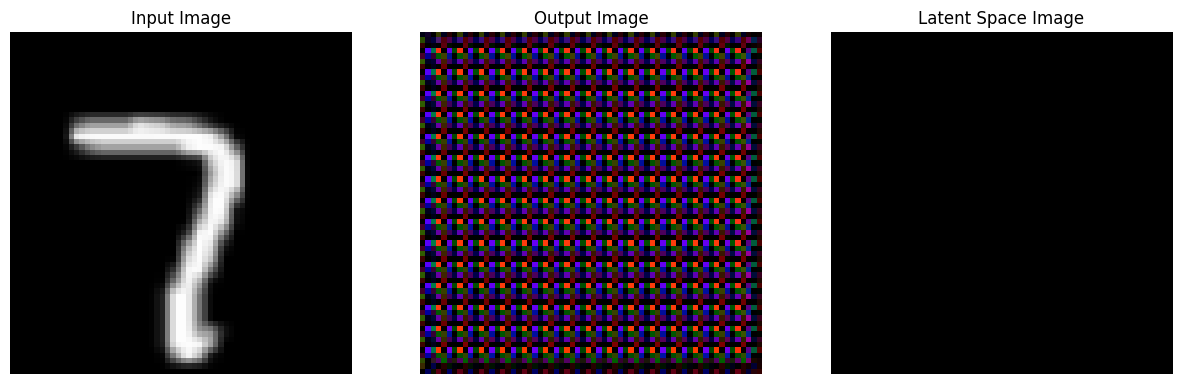

In [ ]:
import matplotlib.pyplot as plt
visualize_samples(sample_output, sample_latent, sample_input)

In [ ]:
import torch
import torch.nn as nn
emb = nn.Embedding(num_embeddings=3, embedding_dim=2)
rd_tensor = torch.rand((8, 2, 16, 16))
beta = 0.2
b, c, h, w = rd_tensor.shape
rd_tensor = rd_tensor.permute(0, 2, 3, 1)
rd_tensor = rd_tensor.reshape((rd_tensor.size(0), -1, rd_tensor.size(-1)))
emb_w = emb.weight[None:].repeat((rd_tensor.size(0), 1, 1))
dist = torch.cdist(rd_tensor, emb_w)
min_encoding_indices = torch.argmin(dist, dim=-1)
emb_output = torch.index_select(input=emb.weight, dim=0, index=min_encoding_indices.view(-1))
# emb_output = emb_output.reshape(rd_tensor.size(0), -1, emb_output.size(-1))
rd_tensor = rd_tensor.reshape((-1, rd_tensor.size(-1)))
com_loss = torch.mean((emb_output.detach() - rd_tensor)**2)
book_loss = torch.mean((emb_output - rd_tensor.detach())**2)
vq_loss = book_loss + com_loss * beta
emb_output = rd_tensor + (emb_output - rd_tensor).detach()
emb_output = emb_output.reshape(b, h, w, c)
emb_output = emb_output.permute(0, 3, 1, 2)

In [ ]:
emb_output.shape

torch.Size([8, 2, 16, 16])

In [ ]:
min_encoding_indices

tensor([[ 76,  95,  56],
        [ 44,  33,  33],
        [ 33,   4,   4],
        [106,  98,  98],
        [ 34,  49,  49],
        [ 13,  16,  16],
        [121,  52,  52],
        [ 40,  30,  55]])

In [ ]:
emb_w = emb.weight[None:].repeat((rd_tensor.size(0), 1, 1))

In [ ]:
rd_tensor.shape, emb_w.shape

(torch.Size([8, 144, 2]), torch.Size([8, 3, 2]))

In [ ]:
dist = torch.cdist(rd_tensor, emb_w)

In [ ]:
dist.shape

torch.Size([8, 144, 3])

In [ ]:
rd_tensor.shape

torch.Size([8, 576, 3])